# Chapter 22

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint

In [1]:
from os.path import exists

filename = 'modsim.py'
if not exists(filename)
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    urlretrieve(url+filename, filename)

In the previous chapter we modeled objects moving in one dimension, with and without drag. Now let's move on to two dimensions, and baseball!

In this chapter we model the flight of a baseball including the effect
of air resistance. In the next chapter we use this model to solve an
optimization problem.

## Baseball

To model the flight of a baseball, we have to make some
decisions. To get started, we'll ignore any spin that might be on the ball, and the resulting Magnus force (see <http://modsimpy.com/magnus>). Under this assumption, the ball travels in a vertical plane, so we'll run simulations in two dimensions, rather than three.

Air resistance has a substantial effect on most projectiles in air, so
we will include a drag force.

To model air resistance, we'll need the mass, frontal area, and drag
coefficient of a baseball. Mass and diameter are easy to find (see
<http://modsimpy.com/baseball>). Drag coefficient is only a little
harder; according to *[The Physics of Baseball](https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC)*, the drag coefficient of a baseball is approximately 0.33 (with no units).

However, this value *does* depend on velocity. At low velocities it
might be as high as 0.5, and at high velocities as low as 0.28.
Furthermore, the transition between these regimes typically happens
exactly in the range of velocities we are interested in, between 20 m/s and 40 m/s.

Nevertheless, we'll start with a simple model where the drag coefficient does not depend on velocity; as an exercise at the end of the chapter, you will have a chance to implement a more detailed model and see what effect is has on the results.

But first we need a new computational tool, the `Vector` object.

## Vectors

Now that we are working in two dimensions, it will be useful to
work with **vector quantities**, that is, quantities that represent both a magnitude and a direction. We will use vectors to represent positions, velocities, accelerations, and forces in two and three dimensions.

ModSim provides a function called `Vector` the creates a Pandas `Series` that contains the **components** of the vector.
In a `Vector` that represents a position in space, the components are the $x$ and $y$ coordinates in 2-D, plus a $z$ coordinate if the `Vector` is in 3-D.

You can create a `Vector` by specifying its components. The following
`Vector` represents a point 3 units to the right (or east) and 4 units up (or north) from an implicit origin:

In [2]:
from modsim import Vector

A = Vector(3, 4)
A

x    3
y    4
dtype: int64

You can access the components of a `Vector` by name using the dot
operator, like this:

In [3]:
A.x, A.y

(3, 4)

You can also access them by index using brackets, like this:

In [4]:
A[0], A[1]

(3, 4)

`Vector` objects support most mathematical operations, including
addition and subtraction:

In [5]:
B = Vector(1, 2)
B

x    1
y    2
dtype: int64

In [6]:
A + B

x    4
y    6
dtype: int64

In [7]:
A - B

x    2
y    2
dtype: int64

For the definition and graphical interpretation of these operations, see <http://modsimpy.com/vecops>.

We can specify a `Vector` with coordinates `x` and `y`, as in the previous examples.
Equivalently, we can specify a `Vector` with a magnitude and angle.

**Magnitude** is the length of the vector: if the `Vector` represents a position, magnitude is the distance from the origin; if it represents a velocity, magnitude is speed, that is, how fast the object is moving, regardless of direction.

The **angle** of a `Vector` is its direction, expressed as an angle in radians from the positive $x$ axis. In the Cartesian plane, the angle 0 rad is due east, and the angle $\pi$ rad is due west.

ModSim provides functions to compute the magnitude and angle of a `Vector`.  For example, here are the magnitude and angle of `A`:

In [8]:
from modsim import vector_mag, vector_angle

mag = vector_mag(A)
theta = vector_angle(A)
mag, theta

(5.0, 0.9272952180016122)

The magnitude is 5 because the length of `A` is the hypotenuse of a 3-4-5 triangle.

The result from `vector_angle` is in radians, and most Python functions, like `sin` and `cos`, work with radians. 
But many people think more naturally in degrees. 
Fortunately, NumPy provides a function to convert radians to degrees:

In [9]:
from numpy import rad2deg

angle = rad2deg(theta)
angle

53.13010235415598

And a function to convert degrees to radians:

In [10]:
from numpy import deg2rad

theta = deg2rad(angle)
theta

0.9272952180016122

Following convention, I'll use `angle` for a value in degrees and `theta` for a value in radians.

If you are given an angle and velocity, you can make a `Vector` using
`pol2cart`, which converts from polar to Cartesian coordinates. For example, here's a new `Vector` with the same angle and magnitude of `A`:

In [11]:
from modsim import pol2cart

x, y = pol2cart(theta, mag)
Vector(x, y)

x    3.0
y    4.0
dtype: float64

Another way to represent the direction of `A` is a **unit vector**,
which is a vector with magnitude 1 that points in the same direction as
`A`. You can compute a unit vector by dividing a vector by its
magnitude:

In [12]:
A / vector_mag(A)

x    0.6
y    0.8
dtype: float64

We can do the same thing using the `vector_hat` function, so named because unit vectors are conventionally decorated with a hat, like this: $\hat{A}$.

In [13]:
from modsim import vector_hat

vector_hat(A)

x    0.6
y    0.8
dtype: float64

Now let's get back to the game.

## Simulating baseball flight

Let's simulate the flight of a baseball that is batted from home plate
at an angle of 45° and initial speed 40 m/s. We'll use the center of home plate as the origin, a horizontal x-axis (parallel to the ground), and vertical y-axis (perpendicular to the ground). The initial height is about 1 m.

In [14]:
from modsim import Params

params = Params(
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    velocity = 40,  # m / s

    mass = 145e-3,    # kg 
    diameter = 73e-3, # m 
    C_d = 0.33,     # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10,     # s
)

I got the mass and diameter of the baseball from [Wikipedia](https://en.wikipedia.org/wiki/Baseball_(ball)) and the coefficient of drag is from *[The Physics of Baseball](https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC)*:

The density of air, `rho`, is based on a temperature of 20 °C at sea level (see <http://modsimpy.com/tempress>). 
And we'll need the acceleration of gravity, `g`.

The following function uses these quantities to make a `System` object.

In [15]:
from modsim import State, System, pol2cart
from numpy import pi, deg2rad

def make_system(params):
    
    # convert angle to degrees
    theta = deg2rad(params.angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.velocity)
    
    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area,
                 )

`make_system` uses `deg2rad` to convert `angle` to radians and
`pol2cart` to compute the $x$ and $y$ components of the initial
velocity.

`init` is a `State` object with four state variables:

* `x` and `y` are the components of position.

* `vx` and `vy` are the components of velocity.

The `System` object also contains `t_end`, which is 10 seconds, long enough for the ball to land on the ground.
Here's the `System` object.

In [16]:
system = make_system(params)

And here's the initial `State`:

In [17]:
system.init

x      0.000000
y      1.000000
vx    28.284271
vy    28.284271
dtype: float64

Next we need a function to compute drag force:

In [18]:
def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag

This function takes `V` as a `Vector` and returns `f_drag` as a
`Vector`. 

* It uses `vector_mag` to compute the magnitude of `V`, 
and the drag equation to compute the magnitude of the drag force, `mag`.

* Then it uses `vector_hat` to compute `direction`, which is a unit vector in the opposite direction of `V`.

* Finally, it computes the drag force vector by multiplying `mag` and `direction`.

We can test it like this:

In [19]:
from modsim import Vector

vx, vy = system.init.vx, system.init.vy
V_test = Vector(vx, vy)
drag_force(V_test, system)

x   -0.937574
y   -0.937574
dtype: float64

The result is a `Vector` that represents the drag force on the baseball, in Newtons, under the initial conditions.

Now we're ready for a slope function:

In [20]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / mass
    a_grav = g * Vector(0, -1)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y

As usual, the parameters of the slope function are a time, a `State` object, and a `System` object. 
In this example, we don't use `t`, but we can't leave it out because when `run_solve_ivp` calls the slope function, it always provides the same arguments, whether they are needed or not.

`slope_func` unpacks the `State` object into variables `x`, `y`, `vx`, and `vy`.
Then it packs `vx` and `vy` into a `Vector`, which it uses to compute drag force and acceleration due to drag, `a_drag`.

To represent acceleration due to gravity, it makes a `Vector` with magnitude `g` in the negative $y$ direction.

The total acceleration of the baseball, `A`, is the sum of accelerations due to gravity and drag.

The return value is a sequence that contains:

* The components of velocity, `V.x` and `V.y`.

* The components of acceleration, `A.x` and `A.y`.

Together, these components represent the slope of the state variables, because `V` is the derivative of position and `A` is the derivative of velocity.

As always, we can test the slope function by running it with the initial conditions:

In [21]:
slope_func(0, system.init, system)

(28.284271247461902, 28.2842712474619, -6.466030881564545, -16.266030881564546)

Using vectors to represent forces and accelerations makes the code
concise, readable, and less error-prone. In particular, when we add
`a_grav` and `a_drag`, the directions are likely to be correct, because they are encoded in the `Vector` objects.

We're almost ready to run the simulation.  The last thing we need is an event function that stops when the ball hits the ground.

In [22]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

The event function takes the same parameters as the slope function, and returns the $y$ coordinate of position. When the $y$ coordinate passes through 0, the simulation stops.

As we did with `slope_func`, we can test `event_func` with the initial conditions.

In [23]:
event_func(0, system.init, system)

1.0

Now we're ready to run the simulation:

In [24]:
from modsim import run_solve_ivp

results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

`details` contains information about the simulation, including a message that indicates that a "termination event" occurred; that is, the simulated ball reached the ground.

`results` is a `TimeFrame` with one column for each of the state variables:

In [25]:
results.tail()

,x,y,vx,vy
4.604496,93.473971,8.296642e+00,15.013486,-19.334826
4.704594,94.966756,6.325368e+00,14.802553,-20.038175
4.804692,96.438515,4.284486e+00,14.590855,-20.726780
4.904789,97.889087,2.175515e+00,14.378566,-21.400392
5.004887,99.318296,-7.105427e-15,14.165894,-22.058763


We can get the flight time like this:

In [26]:
flight_time = results.index[-1]
flight_time

5.004887034868351

And the final state like this:

In [27]:
final_state = results.iloc[-1]
final_state

x     9.931830e+01
y    -7.105427e-15
vx    1.416589e+01
vy   -2.205876e+01
Name: 5.004887034868351, dtype: float64

The final value of `y` is close to 0, as it should be.  The final value of `x` tells us how far the ball flew, in meters.

In [28]:
x_dist = final_state.x
x_dist

99.31829628352206

We can also get the final velocity, like this:

In [29]:
final_V = Vector(final_state.vx, final_state.vy)
final_V

x    14.165894
y   -22.058763
dtype: float64

The speed of the ball on impact is about 26 m/s, which is substantially slower than the initial velocity, 40 m/s.

In [30]:
vector_mag(final_V)

26.215674453237636

## Trajectories

To visualize the results, we can plot the $x$ and $y$ components of position like this:

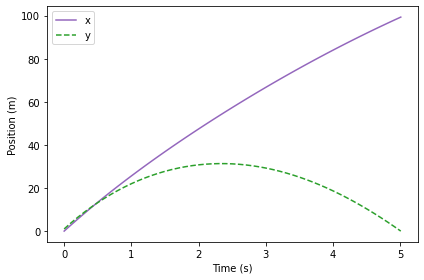

In [31]:
from modsim import decorate

results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

As expected, the $x$ component increases as the ball moves away from home plate. The $y$ position climbs initially and then descends, falling to 0 m near 5.0 s.

Another way to view the results is to plot the $x$ component on the
x-axis and the $y$ component on the y-axis, so the plotted line follows the trajectory of the ball through the plane:

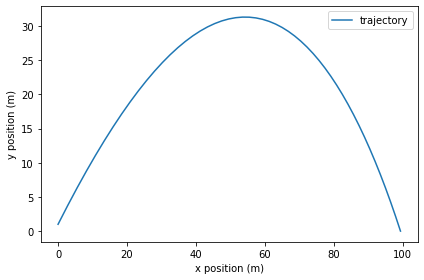

In [32]:
from matplotlib.pyplot import plot

def plot_trajectory(results):
    plot(results.x, results.y, label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)

This way of visualizing the results is called a **trajectory plot** (see <http://modsimpy.com/trajec>).

A trajectory plot can be easier to interpret than a time series plot,
because it shows what the motion of the projectile would look like (at
least from one point of view). Both plots can be useful, but don't get
them mixed up! If you are looking at a time series plot and interpreting it as a trajectory, you will be very confused.

## Animation

One of the best ways to visualize the results of a physical model is animation.  If there are problems with the model, animation can make them apparent.

The ModSimPy library provides `animate`, which takes as parameters a `TimeSeries` and a draw function.

The draw function should take as parameters a `State` object and the time.  It should draw a single frame of the animation.

Inside the draw function, you almost always have to call `set_xlim` and `set_ylim`.  Otherwise `matplotlib` auto-scales the axes, which is usually not what you want.

In [33]:
xs = results.x
ys = results.y

def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=(xs.min(), xs.max()),
             ylim=(ys.min(), ys.max()),
            )

In [34]:
from modsim import animate

# animate(results, draw_func)

## Exercises

**Exercise:** Run the simulation with and without air resistance.  How wrong would we be if we ignored drag?

In [35]:
# Hint

system2 = make_system(params.set(C_d=0))

In [36]:
# Solution

results2, details2 = run_solve_ivp(system2, slope_func, 
                                   events=event_func)
details.message

'A termination event occurred.'

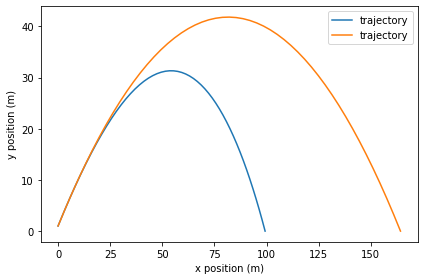

In [37]:
# Solution

plot_trajectory(results)
plot_trajectory(results2)

In [38]:
# Solution

x_dist2 = results2.iloc[-1].x
x_dist2

164.25925502413202

In [39]:
# Solution

x_dist2 - x_dist

64.94095874060996

**Exercise:** The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg / meter$^3$.  How much farther would a ball hit with the same velocity and launch angle travel?

In [40]:
# Hint

system3 = make_system(params.set(rho=1.0))

In [41]:
# Solution

results3, details3 = run_solve_ivp(system3, slope_func, 
                                   events=event_func)

x_dist3 = results3.iloc[-1].x
x_dist3

105.78838005859807

In [42]:
# Solution

x_dist3 - x_dist

6.470083775076006

**Exercise:** The model so far is based on the assumption that coefficient of drag does not depend on velocity, but in reality it does.  The following figure, from Adair, [*The Physics of Baseball*](https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC), shows coefficient of drag as a function of velocity.

<img src="https://github.com/AllenDowney/ModSimPy/raw/master/figs/baseball_drag.png" width="400">


I used [an online graph digitizer](https://automeris.io/WebPlotDigitizer/) to extract the data and save it in a CSV file.  Here's how we can read it:

In [43]:
import os

filename = 'baseball_drag.csv'

if not os.path.exists(filename):
    !wget https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/data/baseball_drag.csv

In [44]:
from pandas import read_csv
from modsim import Quantity, units

baseball_drag = read_csv(filename)
mph = Quantity(baseball_drag['Velocity in mph'], units.mph)
mps = mph.to(units.meter / units.second)
baseball_drag.index = mps.magnitude
baseball_drag.index.name = 'Velocity in meters per second'
baseball_drag.head()

,Velocity in mph,Drag coefficient
Velocity in meters per second,,
0.026146,0.058486,0.49965
8.871509,19.845000,0.49878
17.647351,39.476000,0.49704
22.432914,50.181000,0.48225
26.882303,60.134000,0.45004


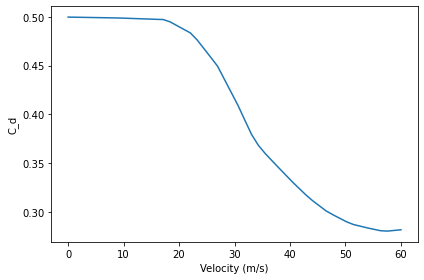

In [45]:
from modsim import interpolate, linspace

drag_interp = interpolate(baseball_drag['Drag coefficient'])
vs = linspace(0, 60)
cds = drag_interp(vs)
plot(vs, cds)
decorate(xlabel='Velocity (m/s)', ylabel='C_d')

Modify the model to include the dependence of `C_d` on velocity, and see how much it affects the results.

In [46]:
# Solution

def drag_force2(V, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    rho, area = system.rho, system.area
    
    C_d = drag_interp(vector_mag(V))
    mag = -rho * vector_mag(V)**2 * C_d * area / 2
    direction = vector_hat(V)
    f_drag = direction * mag
    return f_drag

In [47]:
# Solution

def slope_func2(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = Vector(vx, vy)
    a_drag = drag_force2(V, system) / mass
    a_grav = g * Vector(0, -1)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y

In [48]:
# Solution

system4 = make_system(params)

In [49]:
# Solution

V = Vector(30, 30)
f_drag = drag_force(V, system4)
f_drag

x   -1.054771
y   -1.054771
dtype: float64

In [50]:
# Solution

slope_func(0, system4.init, system4)

(28.284271247461902, 28.2842712474619, -6.466030881564545, -16.266030881564546)

In [51]:
# Solution

results4, details4 = run_solve_ivp(system4, slope_func2, 
                                   events=event_func)
details4.message

'A termination event occurred.'

In [52]:
# Solution

results4.tail()

,x,y,vx,vy
4.525854,85.443182,7.746401e+00,12.556069,-18.457129
4.624243,86.667639,5.898175e+00,12.324797,-19.075086
4.722631,87.869695,3.989943e+00,12.094833,-19.677696
4.821019,89.049363,2.023337e+00,11.866567,-20.265039
4.919407,90.206647,1.065814e-14,11.640440,-20.837214


In [53]:
# Solution

x_dist4 = results4.iloc[-1].x
x_dist4

90.20664656623306

In [54]:
# Solution

x_dist4 - x_dist

-9.111649717288998

### Under the hood

`Vector` 